## MNIST using tensorflow

TF features used:
* data pipeline using tf.data
* learning rate decay

Neural Network Architecture
* 2 hidden layers with 32 and 64 neurons in each and ReLu activations
* using sparse_softmax_cross_entropy which consumes the logits directly instead of the softmax output.  It has softmax computation built within itself
* using a learning rate scheduler to decay learning rate

In [1]:
import os, math, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

Using TensorFlow backend.


# Neural Network Architecture

* A 2 layer hidden network with 64 and 32 hidden neurons going to a 10 layer output layer
* Introducing a softmax layer
* Using a gradient descent optimizer
* Works on batches of 128 images

In [3]:
# Flatten inputs
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1,28*28)

In [7]:
# Building the model pipeline
def model(lr=1e-4):
    
    layer1_num_neurons = 64
    layer2_num_neurons = 32
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = lr
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               2000, 0.98, staircase=True)
    
    with tf.name_scope('Inputs'):
        tf_X = tf.placeholder(shape=(None, 28*28), dtype=tf.float32, name='tf_X')
        tf_y = tf.placeholder(shape=(None,), dtype=tf.int32, name='tf_y')
    
    # First hidden layer
    with tf.name_scope('Layer1'):
        W1 = tf.Variable(tf.random_normal(shape=(28*28, layer1_num_neurons), mean=0, stddev=1e-3), name='W1')
        b1 = tf.Variable(tf.random_uniform(shape=(layer1_num_neurons,)), name='b1')
        l1_act_in = tf.add(tf.matmul(tf_X, W1),b1, name='l1_act_in')
        l1_out = tf.nn.relu(l1_act_in, name='l1_out')
        tf.add_to_collection('Weights', W1)
        tf.add_to_collection('Biases', b1)
    
    # Second hidden layer
    with tf.name_scope('Layer2'):
        W2 = tf.Variable(tf.random_normal(shape=(layer1_num_neurons, layer2_num_neurons), mean=0, stddev=1e-3), name='W2')
        b2 = tf.Variable(tf.random_uniform(shape=(layer2_num_neurons,)), name='b2')
        l2_act_in = tf.add(tf.matmul(l1_out, W2),b2, name='l2_act_in')
        l2_out = tf.nn.relu(l2_act_in,name='l2_out')
        tf.add_to_collection('Weights', W2)
        tf.add_to_collection('Biases', b2)
        
    # 3rd layer with num label neurons
    with tf.name_scope('FinalLayer'):
        Wf = tf.Variable(tf.random_normal(shape=(layer2_num_neurons, 10), mean=0, stddev=1e-3), name='Wf')
        bf = tf.Variable(tf.random_uniform(shape=(10,)), name='bf')
        logits = tf.add(tf.matmul(l2_out, Wf),bf, name='logits_in')
        logits = tf.nn.relu(logits,name='logits')
        tf.add_to_collection('Weights', Wf)
        tf.add_to_collection('Biases', bf)
        
    # Accuracy computation
    with tf.name_scope('AccuracyComputation'):
        pred_labels = tf.cast(tf.argmax(logits, axis=1), tf.int32)
        bool_check = tf.equal(pred_labels, tf_y)
        accuracy = 100.*tf.reduce_mean(tf.cast(bool_check, tf.float32))
        
    with tf.name_scope('LossOpt'):
        #Loss function
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=tf_y, logits=logits), name='loss')
        tf.add_to_collection('Loss', loss)
        #Optimization
        train_op = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(loss, global_step = global_step)
#         train_op = tf.train.AdagradOptimizer(learning_rate=lr).minimize(loss)
    
    return tf_X, tf_y, learning_rate, logits, loss, train_op, accuracy

In [10]:
num_epochs = 500
batch_size = 128
num_batches = X_train.shape[0]/batch_size
print 'Num Steps --> Num batches {} Num Epochs {} '.format(num_batches, num_epochs)

tf.reset_default_graph()

# Using tf.data to create an iterator for the batches
train_X_tf = tf.placeholder(X_train.dtype, X_train.shape)
train_y_tf = tf.placeholder(y_train.dtype, y_train.shape)

dataset = tf.data.Dataset.from_tensor_slices((train_X_tf, train_y_tf))
dataset = dataset.shuffle(buffer_size=X_train.shape[0]).repeat(num_epochs)
dataset = dataset.batch(batch_size=batch_size)

d_iterator = dataset.make_initializable_iterator()
next_batch = d_iterator.get_next()

tf_X, tf_y, curr_lr, logits, loss, train_op, accuracy = model(1e-2)

init_op = tf.global_variables_initializer()

batch = 0

with tf.Session() as sess:
    
    start_time = time.time()
    
    sess.run(init_op)
    
    sess.run(d_iterator.initializer, feed_dict={train_X_tf:X_train, train_y_tf: y_train})
    overall_test_loss = []
    overall_train_loss = []
    overall_test_accuracy = []
    overall_train_accuracy = []
    
    while True:
        batch += 1
        epoch = int(math.ceil(batch*batch_size*1. / X_train.shape[0]))
        try:
            batch_X, batch_y = sess.run(next_batch)
        except tf.errors.OutOfRangeError:
            print 'End of dataset'
            break

        train_loss, _, logits_, accuracy_, curr_lr_ = sess.run([loss, train_op, logits, accuracy, curr_lr], 
                                                   feed_dict={tf_X:batch_X, tf_y:batch_y})
                
        if batch % (num_batches/2) == 0:
            test_loss, test_accuracy = sess.run([loss, accuracy], feed_dict={tf_X:X_test, tf_y:y_test})
            train_loss, train_accuracy = sess.run([loss, accuracy], feed_dict={tf_X:batch_X, tf_y:batch_y})

            overall_test_loss.append(test_loss)
            overall_train_loss.append(train_loss)
            overall_test_accuracy.append(test_accuracy)
            overall_train_accuracy.append(train_accuracy)

        if epoch % 50 == 0 and batch %num_batches == 0:
            print 'Epoch: {} Batch: {} lr {} train accur. {} test accur. {} Elapsed time {} secs'.format(epoch, 
                                    int(math.ceil((batch - 1e-8)% num_batches)),
                                    round(curr_lr_,5),
                                    round(train_accuracy,2), round(test_accuracy,2),
                                    round(time.time() - start_time,2))
            start_time = time.time()

Num Steps --> Num batches 390 Num Epochs 500 
Epoch: 50 Batch: 390 lr 0.00834 train accur. 94.53 test accur. 93.23 Elapsed time 47.28 secs
Epoch: 100 Batch: 390 lr 0.00681 train accur. 94.53 test accur. 95.27 Elapsed time 47.15 secs
Epoch: 150 Batch: 390 lr 0.00557 train accur. 97.66 test accur. 95.64 Elapsed time 46.86 secs
Epoch: 200 Batch: 390 lr 0.00464 train accur. 98.44 test accur. 95.96 Elapsed time 47.02 secs
Epoch: 250 Batch: 390 lr 0.00379 train accur. 98.44 test accur. 96.02 Elapsed time 49.78 secs
Epoch: 300 Batch: 390 lr 0.0031 train accur. 97.66 test accur. 96.15 Elapsed time 46.53 secs
Epoch: 350 Batch: 390 lr 0.00253 train accur. 97.66 test accur. 96.15 Elapsed time 46.13 secs
Epoch: 400 Batch: 390 lr 0.00211 train accur. 98.44 test accur. 96.2 Elapsed time 46.62 secs
Epoch: 450 Batch: 390 lr 0.00172 train accur. 97.66 test accur. 96.21 Elapsed time 46.76 secs
Epoch: 500 Batch: 390 lr 0.00141 train accur. 96.09 test accur. 96.25 Elapsed time 46.34 secs
End of dataset


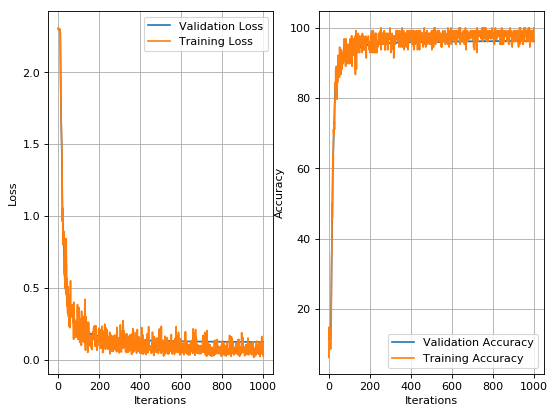

In [11]:
# Plotting
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(range(len(overall_test_loss)),overall_test_loss, label='Validation Loss')
plt.plot(range(len(overall_train_loss)),overall_train_loss, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(len(overall_test_accuracy)),overall_test_accuracy, label='Validation Accuracy')
plt.plot(range(len(overall_train_accuracy)),overall_train_accuracy, label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()